In [1]:
import yfinance as yf
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from array import array 
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import plotly.express as px

In [2]:
ticker = yf.Ticker('UL')
df = ticker.history(period="max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-25,0.000000,0.343938,0.343938,0.343938,18000,0.0,0.0
1980-03-26,0.343938,0.343938,0.343938,0.343938,0,0.0,0.0
1980-03-27,0.343938,0.343938,0.343938,0.343938,0,0.0,0.0
1980-03-28,0.000000,0.330362,0.330362,0.330362,3600,0.0,0.0
1980-03-31,0.330362,0.330362,0.330362,0.330362,0,0.0,0.0
...,...,...,...,...,...,...,...
2022-10-24,44.180000,44.599998,43.599998,44.450001,5578200,0.0,0.0
2022-10-25,44.650002,45.160000,44.650002,45.130001,2600200,0.0,0.0
2022-10-26,44.279999,45.160000,44.259998,44.980000,2765000,0.0,0.0


In [3]:
# ploting entire data close data frame
fig = px.line(df, x=df.index
, y="Close", title='Unilever stock price')
fig.show()

In [4]:
# Create new data frame wih only close column
data= df[['Close']]
# Convert data to numpy array
dataset= data.values
dataset
# Get the number of rows to train the model on (80% train|20% val)
training_data_len= math.ceil(len(dataset)*.8)
training_data_len

8594

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Function to make windowing data set from an array
    window_size: range between X and y data (int) 
    batch_size: size of batch (int)
    shuffle_buffer: the number of elements from this dataset from which the new dataset will sample (int)     
    """
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    return ds.batch(batch_size).prefetch(1)

In [6]:
#split data set
train = dataset[:training_data_len]
valid = dataset[training_data_len-60:]

#scalling val and train data
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train)
val= scaler.transform(valid)

# windowing dataset
window_size=60
batch_size=100
shuffle_buffer=1000
train=windowed_dataset(train, window_size, batch_size, shuffle_buffer)
val=windowed_dataset(val, window_size, batch_size, shuffle_buffer)

In [7]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(100, return_sequences = True, input_shape = (window_size, 1)))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(100, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
#set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02)
#set callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min', patience=30,
                                                  restore_best_weights=True)
#Compile model
model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=["mae"],)
#fit model
hist=model.fit(train, epochs = 50, batch_size = 32,validation_data=val, callbacks=[early_stopping])

Epoch 1/50
86/86 [==============================] - 21s 191ms/step - loss: 0.0411 - mae: 0.0411 - val_loss: 0.2840 - val_mae: 0.2840
Epoch 2/50
86/86 [==============================] - 15s 169ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0731 - val_mae: 0.0731
Epoch 3/50
86/86 [==============================] - 15s 170ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0752 - val_mae: 0.0752
Epoch 4/50
86/86 [==============================] - 15s 171ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0158 - val_mae: 0.0158
Epoch 5/50
86/86 [==============================] - 15s 179ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 6/50
86/86 [==============================] - 15s 176ms/step - loss: 0.0163 - mae: 0.0163 - val_loss: 0.1884 - val_mae: 0.1884
Epoch 7/50
86/86 [==============================] - 15s 173ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 8/50
86/86 [==============================] - 14s 166ms/step - 

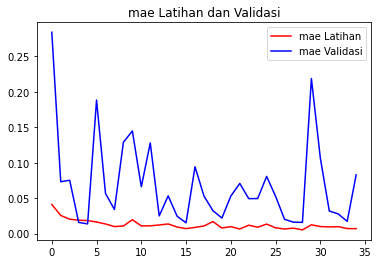

<Figure size 432x288 with 0 Axes>

In [9]:
acc = hist.history['mae']
val_acc = hist.history['val_mae']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='mae Latihan')
plt.plot(epochs, val_acc, 'b', label='mae Validasi')
plt.title('mae Latihan dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [10]:
# scalling validation data
scale_valid=scaler.transform(valid)

#Create the testing data set
X_test = []
y_test = scale_valid[60:]
for i in range(60,len(scale_valid)):
    X_test.append((scale_valid[i-60:i, 0]))
y_test

array([[0.98554817],
       [0.98870955],
       [0.97561278],
       ...,
       [1.33557163],
       [1.3272009 ],
       [1.35829235]])

In [11]:
# reshape data
X_test= np.array(X_test)
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1 ))

In [12]:
#predict and inverse scalling
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

68/68 [==============================] - 2s 20ms/step


In [13]:
# split train and valid data for visualization
train= data[:training_data_len]
valid_df= data[training_data_len:]
valid_df['Predictions']= predictions

C:\Users\USER\AppData\Local\Temp\ipykernel_6164\415922418.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



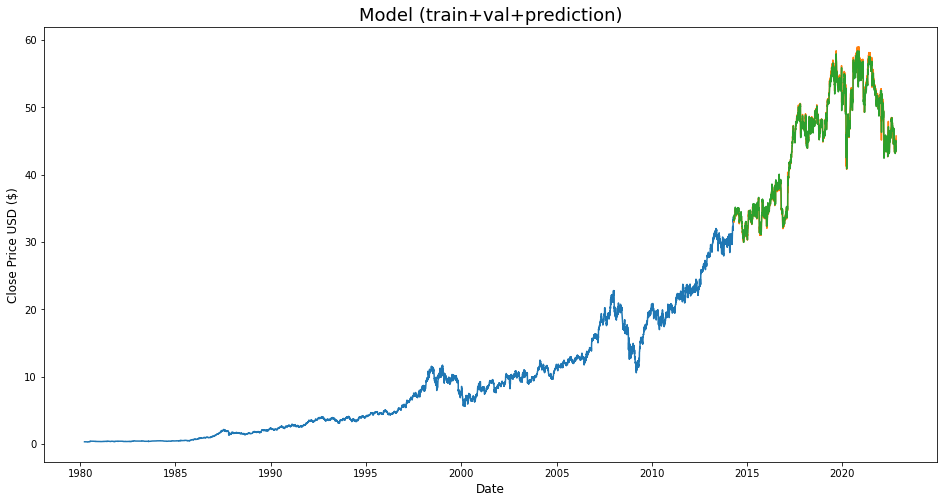

In [14]:
plt.figure(figsize=(16,8))
plt.title('Model (train+val+prediction)',fontsize=18)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price USD ($)',fontsize=12)
plt.plot(train['Close'])
plt.plot(valid_df[['Close','Predictions']])
plt.show()

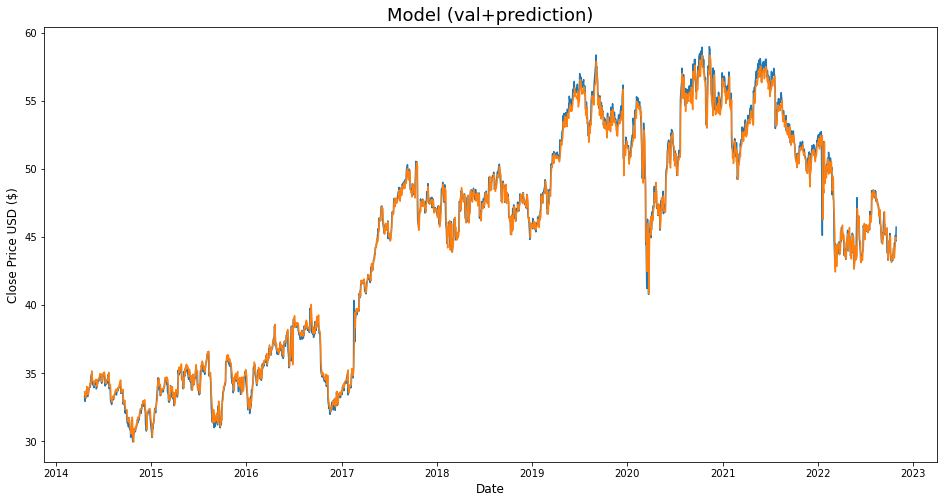

In [15]:
plt.figure(figsize=(16,8))
plt.title('Model (val+prediction)',fontsize=18)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price USD ($)',fontsize=12)
plt.plot(valid_df[['Close','Predictions']])
plt.show()

In [16]:
threshold_mae = (data.max() - data.min()) * 10/100
from sklearn.metrics import mean_absolute_error as mae
pred_mae= mae(data[training_data_len:],predictions)

print('threshold_mae: ',threshold_mae)
print('prediction_mae: ',pred_mae)


threshold_mae:  Close    5.868769
dtype: float64
prediction_mae:  0.45671544794263785


# Conclussion

we achive mae score less than 10 % mae threshold.
the threshold was 5.8 with our model only 0.46

the model I use was LSTM
with Learning rate 1.e-2